# Optimizer Example
Jena Climate ANN example showing comparsion between Adam and *newer* optimizers.
This is a regression model, using 3-hour data.

Richard Henry, 26-Jul-2024

In [1]:
#Import Libararies
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
plt.style.use('fivethirtyeight')

Test Libraries

In [2]:
# Check python version
from platform import python_version
print(python_version())
#3.12.3

3.12.3


In [3]:
# Check tensorflow version
tf.__version__
#2.16.1

'2.17.0'

In [4]:
# Check keras version
tf.keras.__version__
#3.4.1

'3.4.1'

|Dataset|Architecture|Group|Type|
|---|---|---|---|
|Jena3|ANN|Modern|Regression|

In [5]:
# Load Data (Already cleaned and decimated)
df3=pd.read_csv('dataset/Jena_climate/cleanJena3.csv')

In [6]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23363 entries, 0 to 23362
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   p (mbar)       23363 non-null  float64
 1   VPact (mbar)   23363 non-null  float64
 2   Tdew (degC)    23363 non-null  float64
 3   T (degC)       23363 non-null  float64
 4   max. wv (m/s)  23363 non-null  float64
 5   NSwind         23363 non-null  float64
 6   EWwind         23363 non-null  float64
 7   year           23363 non-null  int64  
 8   month          23363 non-null  int64  
 9   day            23363 non-null  int64  
 10  hour           23363 non-null  int64  
dtypes: float64(7), int64(4)
memory usage: 2.0 MB


In [7]:
df3.describe()

,p (mbar),VPact (mbar),Tdew (degC),T (degC),max. wv (m/s),NSwind,EWwind,year,month,day,hour
count,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000
mean,989.216246,9.533017,4.954671,9.456338,3.533382,-0.631798,-0.415655,2012.497068,6.517399,15.713222,10.500449
std,8.353071,4.184973,6.730860,8.428081,2.339862,1.983549,1.553730,2.289905,3.448433,8.799298,6.873702
min,942.720000,0.810000,-24.800000,-22.760000,0.000000,-10.783959,-7.148867,2009.000000,1.000000,1.000000,0.000000
25%,984.200000,6.220000,0.240000,3.340000,1.760000,-1.480647,-1.372670,2010.000000,4.000000,8.000000,6.000000
50%,989.590000,8.860000,5.210000,9.440000,2.980000,-0.637933,-0.296919,2012.000000,7.000000,16.000000,12.000000
75%,994.730000,12.360000,10.080000,15.480000,4.730000,0.306138,0.432981,2014.000000,10.000000,23.000000,15.000000
max,1015.170000,28.040000,22.940000,36.460000,18.780000,7.709359,6.966350,2017.000000,12.000000,31.000000,21.000000


In [8]:
# Model / data parameters
blk_len=16*8      #Look back at two weeks of data
stp_len=8         #look forward 24 hours
row_len=len(df3)   #total records (last target location)
col_len=11         #total variables
bat_len=64*8      #batch size of 2 months
epo_len=32         #32 epochs
val_fra=0.2        #use 20% of data for validation
pas_len=blk_len+stp_len  #first target location
cut_len=row_len-pas_len  #last start of predictor location

In [9]:
%%time
# Reformat
y_train=df3['T (degC)'].iloc[pas_len:].to_numpy()  #pull out all the targets
#start building predictor deck
xAll=df3.to_numpy()
xTrain=np.zeros([cut_len,blk_len,col_len])
for i in range(cut_len):
    for j in range(blk_len):
            xTrain[i][j][:]=xAll[i+j][:]

CPU times: total: 1.88 s
Wall time: 2.31 s


In [10]:
#Normalize Input Data
fixMe=tf.keras.layers.Normalization()
fixMe.adapt(xTrain)

In [11]:
# Build & train model functions
def model_core():
    model = tf.keras.Sequential(
        [
            tf.keras.Input(shape=(blk_len,col_len)),
            fixMe,
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(64,
                                  activation='relu'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(32,
                                  activation='relu'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(1,
                                  activation='linear')
        ]
    )
    return model
def model_build(myOpti):
    #Build it exactly the same every time
    tf.random.set_seed(19)
    model=model_core()
    model.compile(loss='mean_squared_error',
                  optimizer=myOpti,
                  metrics=['mean_absolute_error'])
    # Reduce variation in training...
    tf.random.set_seed(17)
    print("History Match:")
    myHis=model.fit(xTrain,
                    y_train,
                    batch_size=bat_len,
                    epochs=epo_len,
                    validation_split=val_fra)
    print("\n")
    print("Evaluate Model:")
    myEva=model.evaluate(xTrain,
                         y_train,
                         batch_size=bat_len)
    print("All Sample MSE:",myEva[0])
    print("All Sample MAE:",myEva[1])
    print("\n")
    print("Make Predictions:")
    myPre=model.predict(xTrain)
    print("\n")
    print("Timing:")
    return myHis,myPre

### First Model, Adam

In [12]:
%%time
h0,p0=model_build('adam')

History Match:
Epoch 1/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 73.0251 - mean_absolute_error: 6.6752 - val_loss: 21.5602 - val_mean_absolute_error: 3.7232
Epoch 2/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 23.6859 - mean_absolute_error: 3.8028 - val_loss: 15.6594 - val_mean_absolute_error: 3.1755
Epoch 3/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.6472 - mean_absolute_error: 3.3840 - val_loss: 13.8377 - val_mean_absolute_error: 2.9440
Epoch 4/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.3094 - mean_absolute_error: 3.1551 - val_loss: 13.5594 - val_mean_absolute_error: 2.9157
Epoch 5/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 15.0025 - mean_absolute_error: 3.0249 - val_loss: 13.0706 - val_mean_absolute_error: 2.8619
Epoch 6/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 14.4871 - mean_absolute_error: 2.9711 - val_loss: 12.8625 - val_mean_absolute_error: 2.8326
Epoch 7/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 13.4318 - mean_absolute_err

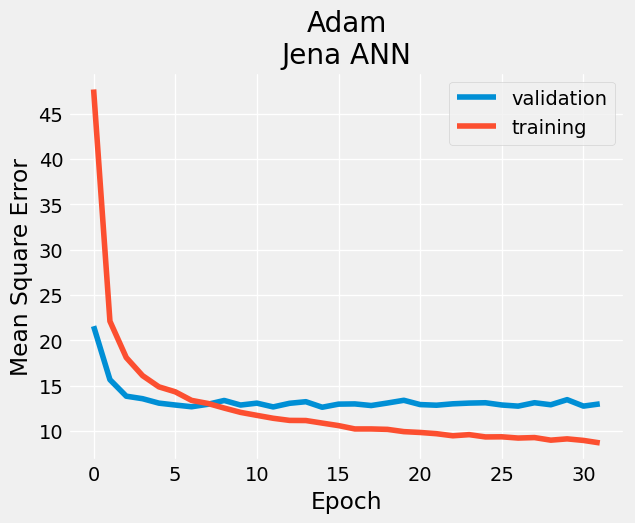

In [13]:
plt.plot(h0.history['val_loss'])
plt.plot(h0.history['loss'])
plt.ylabel('Mean Square Error')
plt.xlabel('Epoch')
plt.legend(['validation','training'])
plt.title('Adam\nJena ANN')
plt.grid(color='white')
plt.show()

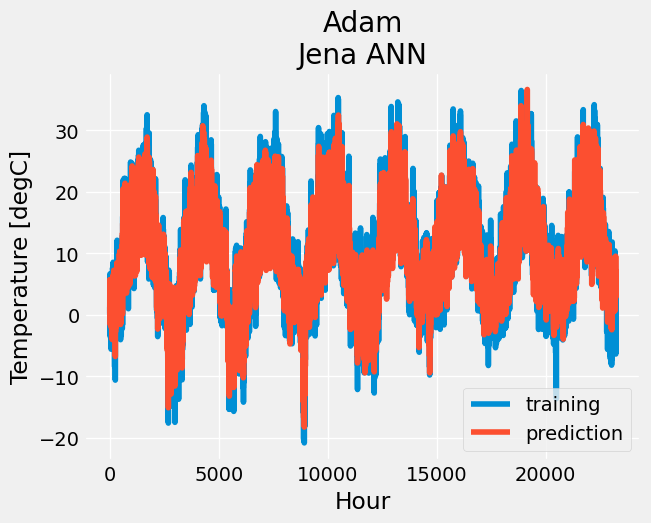

In [14]:
plt.plot(y_train)
plt.plot(p0.flatten())
plt.ylabel('Temperature [degC]')
plt.xlabel('Hour')
plt.legend(['training','prediction'])
plt.title('Adam\nJena ANN')
plt.grid(color='white')
plt.show()

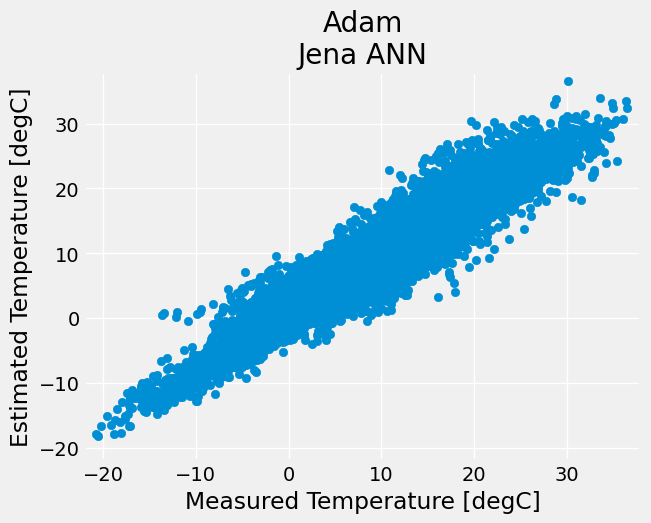

In [15]:
plt.scatter(y_train,p0.flatten())
plt.ylabel('Estimated Temperature [degC]')
plt.xlabel('Measured Temperature [degC]')
plt.title('Adam\nJena ANN')
plt.grid(color='white')
plt.xlim([-22,38])
plt.ylim([-22,38])
plt.show()

### Second Model, Adam with Weight Decay

In [16]:
%%time
h1,p1=model_build('adamw')

History Match:
Epoch 1/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 65.8836 - mean_absolute_error: 6.2792 - val_loss: 28.1827 - val_mean_absolute_error: 4.2906
Epoch 2/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 22.5846 - mean_absolute_error: 3.7336 - val_loss: 18.3874 - val_mean_absolute_error: 3.4232
Epoch 3/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.2350 - mean_absolute_error: 3.3394 - val_loss: 14.5028 - val_mean_absolute_error: 3.0378
Epoch 4/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.3457 - mean_absolute_error: 3.1761 - val_loss: 13.7409 - val_mean_absolute_error: 2.9531
Epoch 5/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 15.1965 - mean_absolute_error: 3.0449 - val_loss: 13.1392 - val_mean_absolute_error: 2.8578
Epoch 6/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 14.1515 - mean_absolute_error: 2.9426 - val_loss: 13.2622 - val_mean_absolute_error: 2.8768
Epoch 7/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 13.3377 - mean_absolute_err

### Third Model, AdaFactor

In [17]:
%%time
h2,p2=model_build('adafactor')

History Match:
Epoch 1/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 133.9121 - mean_absolute_error: 9.5665 - val_loss: 136.4256 - val_mean_absolute_error: 9.7181
Epoch 2/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 98.0301 - mean_absolute_error: 8.1433 - val_loss: 102.3679 - val_mean_absolute_error: 8.3489
Epoch 3/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 65.4611 - mean_absolute_error: 6.5414 - val_loss: 71.4157 - val_mean_absolute_error: 6.8563
Epoch 4/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 43.1229 - mean_absolute_error: 5.1883 - val_loss: 48.7319 - val_mean_absolute_error: 5.5395
Epoch 5/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 33.9086 - mean_absolute_error: 4.5786 - val_loss: 35.8136 - val_mean_absolute_error: 4.7042
Epoch 6/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 29.8819 - mean_absolute_error: 4.2940 - val_loss: 28.3847 - val_mean_absolute_error: 4.2005
Epoch 7/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 27.0885 - mean_absolute_

### 4th Model, LION

In [18]:
%%time
h3,p3=model_build('lion')

History Match:
Epoch 1/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 99.4576 - mean_absolute_error: 7.9232 - val_loss: 24.8512 - val_mean_absolute_error: 3.9819
Epoch 2/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 28.8741 - mean_absolute_error: 4.2049 - val_loss: 16.3681 - val_mean_absolute_error: 3.1956
Epoch 3/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 23.9694 - mean_absolute_error: 3.8290 - val_loss: 15.1903 - val_mean_absolute_error: 3.0271
Epoch 4/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 20.8575 - mean_absolute_error: 3.5776 - val_loss: 14.5447 - val_mean_absolute_error: 2.9733
Epoch 5/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 19.2526 - mean_absolute_error: 3.4132 - val_loss: 15.5654 - val_mean_absolute_error: 3.0854
Epoch 6/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.2748 - mean_absolute_error: 3.3374 - val_loss: 13.8343 - val_mean_absolute_error: 2.9237
Epoch 7/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.9729 - mean_absolute_err

### 5th Model, Adam with Nesterov Momentum

In [19]:
%%time
h4,p4=model_build('nadam')

History Match:
Epoch 1/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 82.0021 - mean_absolute_error: 7.1283 - val_loss: 22.1745 - val_mean_absolute_error: 3.7633
Epoch 2/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 24.1832 - mean_absolute_error: 3.8492 - val_loss: 15.5057 - val_mean_absolute_error: 3.1328
Epoch 3/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 18.2958 - mean_absolute_error: 3.3551 - val_loss: 13.9403 - val_mean_absolute_error: 2.9600
Epoch 4/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.6016 - mean_absolute_error: 3.1947 - val_loss: 13.2481 - val_mean_absolute_error: 2.8721
Epoch 5/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 15.0225 - mean_absolute_error: 3.0443 - val_loss: 13.7742 - val_mean_absolute_error: 2.9534
Epoch 6/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 14.2864 - mean_absolute_error: 2.9633 - val_loss: 13.6446 - val_mean_absolute_error: 2.9304
Epoch 7/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 13.5348 - mean_absolute_err

### 6th Model, Follow the Regularized Leader

In [20]:
%%time
h5,p5=model_build('ftrl')

History Match:
Epoch 1/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 90.2742 - mean_absolute_error: 7.6693 - val_loss: 72.4580 - val_mean_absolute_error: 6.9861
Epoch 2/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 41.9008 - mean_absolute_error: 5.1482 - val_loss: 53.9053 - val_mean_absolute_error: 5.9609
Epoch 3/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 34.3268 - mean_absolute_error: 4.6382 - val_loss: 39.7701 - val_mean_absolute_error: 5.0686
Epoch 4/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 28.8187 - mean_absolute_error: 4.2342 - val_loss: 30.9869 - val_mean_absolute_error: 4.4536
Epoch 5/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 25.5927 - mean_absolute_error: 3.9819 - val_loss: 25.2356 - val_mean_absolute_error: 4.0130
Epoch 6/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 23.4465 - mean_absolute_error: 3.8139 - val_loss: 22.1750 - val_mean_absolute_error: 3.7506
Epoch 7/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 22.0748 - mean_absolute_err

### 7th Model, AdaMax

In [21]:
%%time
h6,p6=model_build('adamax')

History Match:
Epoch 1/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 88.1588 - mean_absolute_error: 7.4084 - val_loss: 31.7093 - val_mean_absolute_error: 4.4396
Epoch 2/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 28.6593 - mean_absolute_error: 4.2184 - val_loss: 21.2482 - val_mean_absolute_error: 3.6638
Epoch 3/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 23.0470 - mean_absolute_error: 3.7781 - val_loss: 18.0275 - val_mean_absolute_error: 3.3625
Epoch 4/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 20.7197 - mean_absolute_error: 3.5724 - val_loss: 16.3142 - val_mean_absolute_error: 3.2029
Epoch 5/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 19.1767 - mean_absolute_error: 3.4244 - val_loss: 15.4791 - val_mean_absolute_error: 3.1151
Epoch 6/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.3651 - mean_absolute_error: 3.3541 - val_loss: 14.7597 - val_mean_absolute_error: 3.0361
Epoch 7/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.6871 - mean_absolute_err

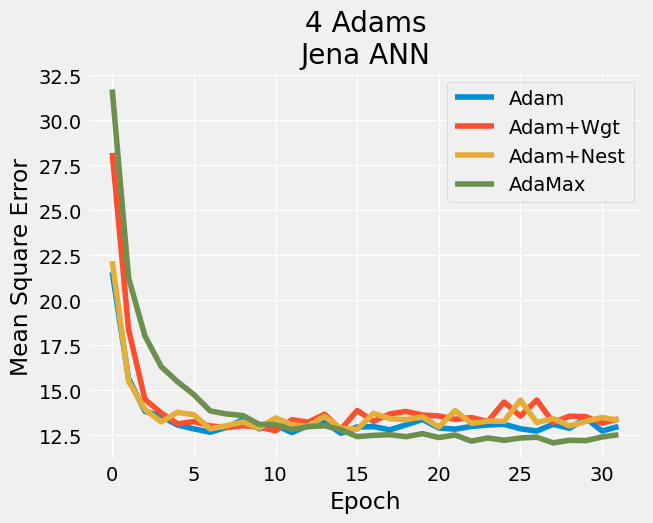

In [22]:
plt.plot(h0.history['val_loss'])
plt.plot(h1.history['val_loss'])
plt.plot(h4.history['val_loss'])
plt.plot(h6.history['val_loss'])
plt.ylabel('Mean Square Error')
plt.xlabel('Epoch')
plt.legend(['Adam','Adam+Wgt','Adam+Nest','AdaMax'])
plt.title('4 Adams\nJena ANN')
plt.grid(color='white')
plt.show()

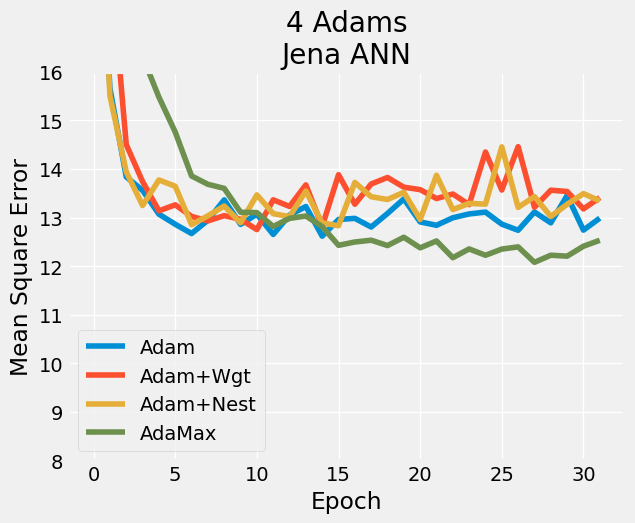

In [23]:
plt.plot(h0.history['val_loss'])
plt.plot(h1.history['val_loss'])
plt.plot(h4.history['val_loss'])
plt.plot(h6.history['val_loss'])
plt.ylabel('Mean Square Error')
plt.xlabel('Epoch')
plt.legend(['Adam','Adam+Wgt','Adam+Nest','AdaMax'])
plt.title('4 Adams\nJena ANN')
plt.ylim([8,16])
plt.grid(color='white')
plt.show()

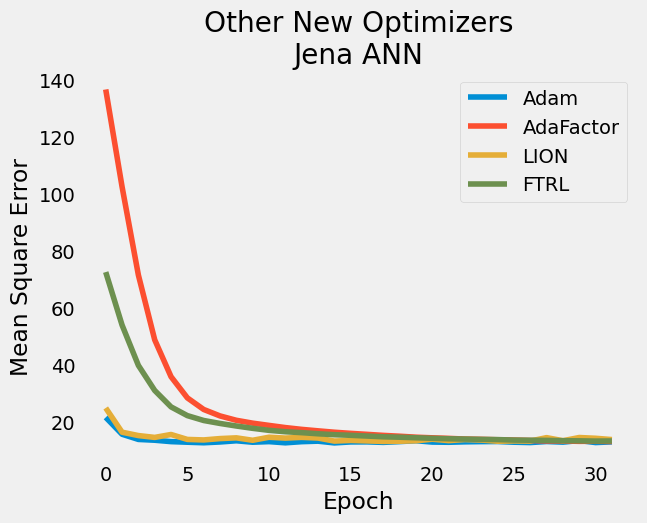

In [24]:
plt.plot(h0.history['val_loss'])
plt.plot(h2.history['val_loss'])
plt.plot(h3.history['val_loss'])
plt.plot(h5.history['val_loss'])
plt.ylabel('Mean Square Error')
plt.xlabel('Epoch')
plt.legend(['Adam','AdaFactor','LION','FTRL'])
plt.title('Other New Optimizers\nJena ANN')
plt.grid()
plt.show()

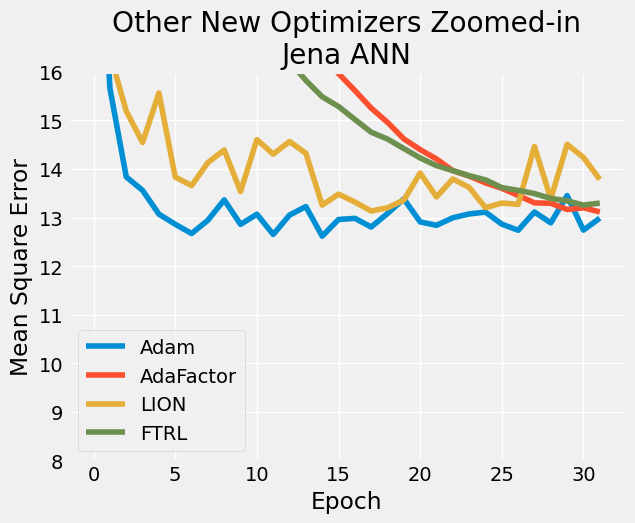

In [25]:
plt.plot(h0.history['val_loss'])
plt.plot(h2.history['val_loss'])
plt.plot(h3.history['val_loss'])
plt.plot(h5.history['val_loss'])
plt.ylabel('Mean Square Error')
plt.xlabel('Epoch')
plt.legend(['Adam','AdaFactor','LION','FTRL'])
plt.title('Other New Optimizers Zoomed-in\nJena ANN')
plt.ylim([8,16])
plt.grid(color='white')
plt.show()

## Model Summary

In [26]:
m=model_core()
m.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ normalization (Normalization)        │ (None, 128, 11)             │              23 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 1408)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 64)                  │          90,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 92,312 (360.60 KB)

 Trainable params: 92,289 (360.50 KB)

 Non-trainable params: 23 (96.00 B)